## Method
- Normalize prediction risk maps (0, 1)
- Get max, average and max_by_cell prediction risk map based on risk matrix obtained from different DB (experiment_10_2_SEPPexp...)
- Compute variance for prediction by DB and multimodal (by operator)

## Hypothesis:
The variance is higher for risk prediction maps associated to multimodal max and max_by_cell operators.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def normalize_grid_prediction(row, column_name):
    xoffset = row[column_name]._xoffset
    yoffset = row[column_name]._yoffset
    xsize = row[column_name]._xsize
    ysize = row[column_name]._ysize
    matrix_norm = row[column_name]._matrix.copy()
    # Uses 1 division and matix.size multiplications, multiplication is faster than division
    matrix_norm *= 1/row[column_name]._matrix.max()
    return open_cp.predictors.GridPredictionArray(xsize=xsize,ysize=ysize,matrix=matrix_norm,xoffset=xoffset,yoffset=yoffset)
    

### Fusion operators

In [5]:
def average_grid_prediction(row):
    xoffset_avg = (row['prediction_siedco']._xoffset + row['prediction_rnmc']._xoffset + row['prediction_nuse']._xoffset)/3
    yoffset_avg = (row['prediction_siedco']._yoffset + row['prediction_rnmc']._yoffset + row['prediction_nuse']._yoffset)/3
    xsize_avg = (row['prediction_siedco']._xsize + row['prediction_rnmc']._xsize + row['prediction_nuse']._xsize)/3
    ysize_avg = (row['prediction_siedco']._ysize + row['prediction_rnmc']._ysize + row['prediction_nuse']._ysize)/3
    matrix_avg = (row['prediction_siedco']._matrix + row['prediction_rnmc']._matrix + row['prediction_nuse']._matrix)/3
    return open_cp.predictors.GridPredictionArray(xsize=xsize_avg,ysize=ysize_avg,matrix=matrix_avg,xoffset=xoffset_avg,yoffset=yoffset_avg)

In [6]:
import operator

def maximum_grid_prediction(row):
    max_intensity = {}
    max_intensity['siedco']=np.sum(row['prediction_siedco']._matrix)
    max_intensity['rnmc']=np.sum(row['prediction_rnmc']._matrix)
    max_intensity['nuse']=np.sum(row['prediction_nuse']._matrix)
    key_max_intensity = max(max_intensity.items(), key=operator.itemgetter(1))[0]
    
    column = 'prediction_'+str(key_max_intensity)
    xoffset_max = row[column]._xoffset
    yoffset_max = row[column]._yoffset
    xsize_max = row[column]._xsize
    ysize_max = row[column]._ysize
    matrix_max = row[column]._matrix
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_max,xoffset=xoffset_max,yoffset=yoffset_max)


In [7]:
def maximum_by_cell(row):
    matrix_1 = np.maximum(row['prediction_siedco']._matrix, row['prediction_rnmc']._matrix)
    matrix_2 = np.maximum(matrix_1, row['prediction_nuse']._matrix)
    # assign any from DB, since all attributes are equal
    xoffset_max = row['prediction_siedco']._xoffset
    yoffset_max = row['prediction_siedco']._yoffset
    xsize_max = row['prediction_siedco']._xsize
    ysize_max = row['prediction_siedco']._ysize
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_2,xoffset=xoffset_max,yoffset=yoffset_max)

### Descriptive metrics

In [8]:
def shannon_entropy(matrix):
    my_array = np.squeeze(np.asarray(matrix))
    # ignore zero values for successful compute of log in entropy eq.
    # https://stats.stackexchange.com/questions/57069/alternative-to-shannons-entropy-when-probability-equal-to-zero
    non_zero_array = my_array[my_array != 0]
    p_normalized = non_zero_array / non_zero_array.sum()
    entropy = -np.sum(p_normalized*np.log2(p_normalized))
    return entropy

In [9]:
from scipy.stats import entropy
import math

def scipy_entropy(matrix, base):
    my_array = np.squeeze(np.asarray(matrix))
    non_zero_array = my_array[my_array != 0]
    return entropy(pk=non_zero_array, base=base)

In [10]:
def variance(matrix):
    return matrix.var()

## Load prediction results

In [11]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [12]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [13]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

## Normalize prediction intensity risk maps

In [14]:
loaded_siedco['prediction_normalized'] = loaded_siedco.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_rnmc['prediction_normalized'] = loaded_rnmc.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_nuse['prediction_normalized'] = loaded_nuse.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)


In [15]:
# Delete not-normalized prediction columns
loaded_siedco.drop(columns=['prediction'], inplace=True)
loaded_rnmc.drop(columns=['prediction'], inplace=True)
loaded_nuse.drop(columns=['prediction'], inplace=True)

### Rename columns to merge df

In [16]:
loaded_siedco = loaded_siedco.rename(columns={'prediction_normalized': 'prediction_siedco', 'eval_pts': 'eval_pts_siedco','initial-date':'initial-date-siedco','final-date':'final-date-siedco'})
loaded_rnmc = loaded_rnmc.rename(columns={'prediction_normalized': 'prediction_rnmc', 'eval_pts': 'eval_pts_rnmc', 'initial-date':'initial-date-rnmc','final-date':'final-date-rnmc'})
loaded_nuse = loaded_nuse.rename(columns={'prediction_normalized': 'prediction_nuse', 'eval_pts': 'eval_pts_nuse', 'initial-date':'initial-date-nuse','final-date':'final-date-nuse'})

## Compute maximum and average prediction

In [17]:
result = pd.concat([loaded_siedco, loaded_rnmc, loaded_nuse], axis=1)

In [18]:
result['average_prediction'] = result.apply(lambda row: average_grid_prediction(row), axis=1)

In [19]:
result['max_prediction'] = result.apply(lambda row: maximum_grid_prediction(row), axis=1)

In [20]:
result['max_cell_prediction'] = result.apply(lambda row: maximum_by_cell(row), axis=1)

### Delete redundant columns

In [21]:
result.drop(columns=['initial-date-rnmc','final-date-rnmc','initial-date-nuse','final-date-nuse'], inplace=True)

In [22]:
result = result.rename(columns={'initial-date-siedco':'initial-date','final-date-siedco':'final-date'})

## Compute variance

In [23]:
result['siedco_variance'] = result.apply(lambda row: variance(row['prediction_siedco']._matrix), axis=1)
result['rnmc_variance'] = result.apply(lambda row: variance(row['prediction_rnmc']._matrix), axis=1)
result['nuse_variance'] = result.apply(lambda row: variance(row['prediction_nuse']._matrix), axis=1)
result['multimodal_average_variance'] = result.apply(lambda row: variance(row['average_prediction']._matrix), axis=1)
result['multimodal_max_variance'] = result.apply(lambda row: variance(row['max_prediction']._matrix), axis=1)
result['multimodal_max_cell_variance'] = result.apply(lambda row: variance(row['max_cell_prediction']._matrix), axis=1)


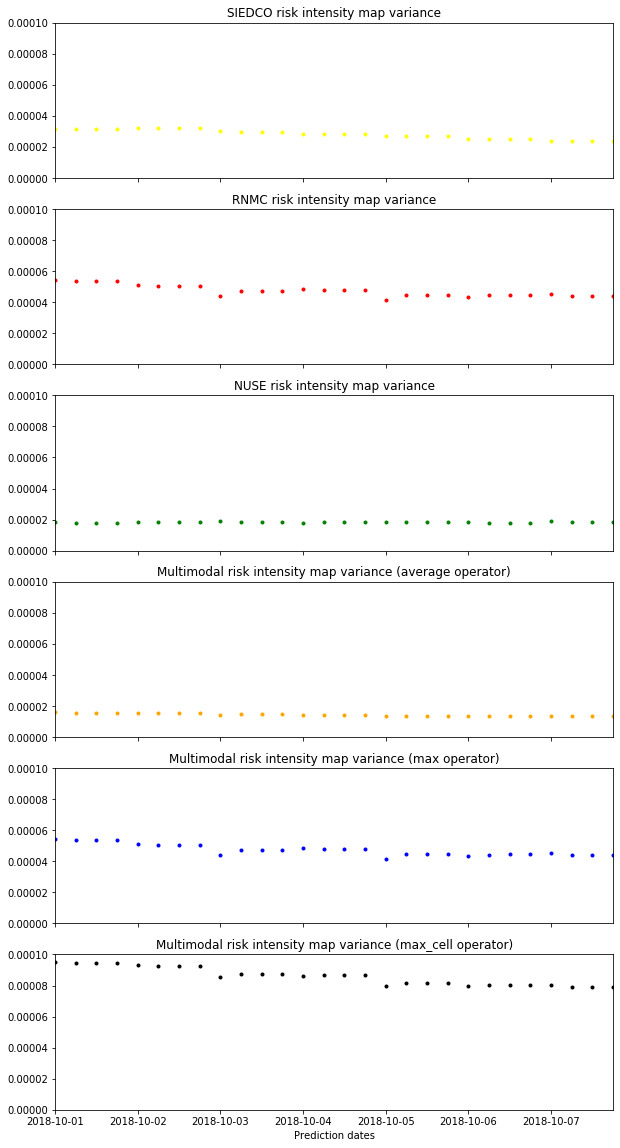

In [25]:
fig, ax = plt.subplots(6,1, figsize=(10,20), sharex=True, sharey=True)
siedco = ax[0].scatter(result['initial-date'].values,result['siedco_variance'].values, marker=".",color='yellow')
rnmc = ax[1].scatter(result['initial-date'].values,result['rnmc_variance'].values, marker=".",color='red')
nuse = ax[2].scatter(result['initial-date'].values,result['nuse_variance'].values, marker=".",color='green')
multimodal_average = ax[3].scatter(result['initial-date'].values,result['multimodal_average_variance'].values, marker=".",color='orange')
multimodal_max = ax[4].scatter(result['initial-date'].values,result['multimodal_max_variance'].values, marker=".",color='blue')
multimodal_max_cell = ax[5].scatter(result['initial-date'].values,result['multimodal_max_cell_variance'].values, marker=".",color='black')
ax[0].set_xlim(result['initial-date'].values[0],result['initial-date'].values[-1])
ax[0].set_ylim(0,0.0001)
ax[0].set_title('SIEDCO risk intensity map variance')
ax[1].set_title('RNMC risk intensity map variance')
ax[2].set_title('NUSE risk intensity map variance')
ax[3].set_title('Multimodal risk intensity map variance (average operator)')
ax[4].set_title('Multimodal risk intensity map variance (max operator)')
ax[5].set_title('Multimodal risk intensity map variance (max_cell operator)')
plt.xlabel('Prediction dates')
plt.show()

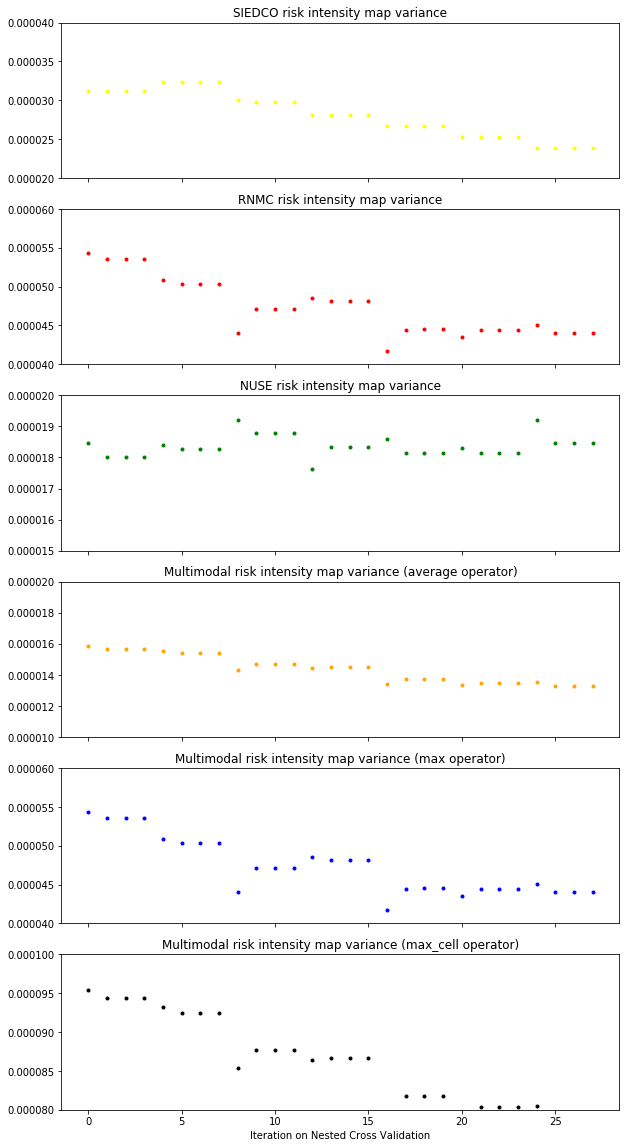

In [36]:
fig, ax = plt.subplots(6,1, figsize=(10,20), sharex=True)
siedco = ax[0].scatter(result.index.values,result['siedco_variance'].values, marker=".",color='yellow')
rnmc = ax[1].scatter(result.index.values,result['rnmc_variance'].values, marker=".",color='red')
nuse = ax[2].scatter(result.index.values,result['nuse_variance'].values, marker=".",color='green')
multimodal_average = ax[3].scatter(result.index.values,result['multimodal_average_variance'].values, marker=".",color='orange')
multimodal_max = ax[4].scatter(result.index.values,result['multimodal_max_variance'].values, marker=".",color='blue')
multimodal_max_cell = ax[5].scatter(result.index.values,result['multimodal_max_cell_variance'].values, marker=".",color='black')
ax[0].set_ylim(0.00002,0.00004)
ax[1].set_ylim(0.00004,0.00006)
ax[2].set_ylim(0.000015,0.00002)
ax[3].set_ylim(0.000010,0.00002)
ax[4].set_ylim(0.00004,0.00006)
ax[5].set_ylim(0.00008,0.0001)
ax[0].set_title('SIEDCO risk intensity map variance')
ax[1].set_title('RNMC risk intensity map variance')
ax[2].set_title('NUSE risk intensity map variance')
ax[3].set_title('Multimodal risk intensity map variance (average operator)')
ax[4].set_title('Multimodal risk intensity map variance (max operator)')
ax[5].set_title('Multimodal risk intensity map variance (max_cell operator)')
plt.xlabel('Iteration on Nested Cross Validation')
plt.show()

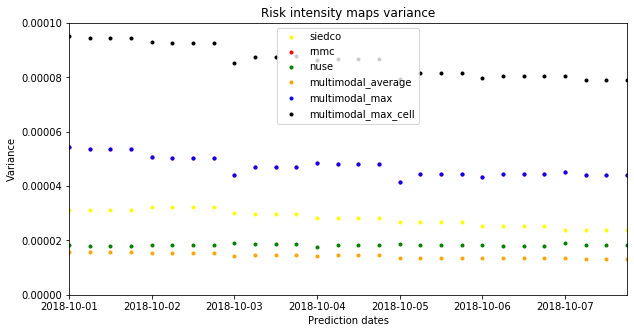

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(result['initial-date'].values,result['siedco_variance'].values, marker=".",color='yellow')
rnmc = ax.scatter(result['initial-date'].values,result['rnmc_variance'].values, marker=".",color='red')
nuse = ax.scatter(result['initial-date'].values,result['nuse_variance'].values, marker=".",color='green')
multimodal_average = ax.scatter(result['initial-date'].values,result['multimodal_average_variance'].values, marker=".",color='orange')
multimodal_max = ax.scatter(result['initial-date'].values,result['multimodal_max_variance'].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(result['initial-date'].values,result['multimodal_max_cell_variance'].values, marker=".",color='black')
ax.set_xlim(result['initial-date'].values[0],result['initial-date'].values[-1])
ax.set_ylim(0,0.0001)
ax.set_title('Risk intensity maps variance')
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Prediction dates')
plt.ylabel('Variance')
plt.show()

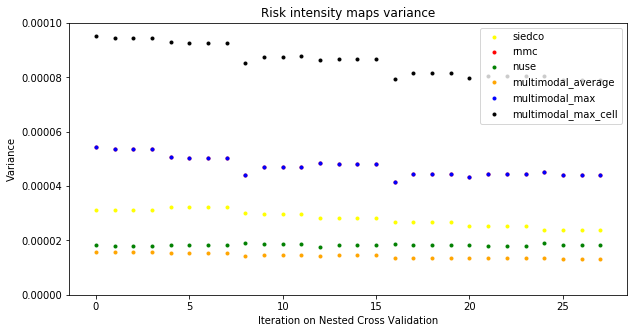

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(result.index.values,result['siedco_variance'].values, marker=".",color='yellow')
rnmc = ax.scatter(result.index.values,result['rnmc_variance'].values, marker=".",color='red')
nuse = ax.scatter(result.index.values,result['nuse_variance'].values, marker=".",color='green')
multimodal_average = ax.scatter(result.index.values,result['multimodal_average_variance'].values, marker=".",color='orange')
multimodal_max = ax.scatter(result.index.values,result['multimodal_max_variance'].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(result.index.values,result['multimodal_max_cell_variance'].values, marker=".",color='black')
ax.set_ylim(0,0.0001)
ax.set_title('Risk intensity maps variance')
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel('Variance')
plt.show()

In [29]:
print(result.mean())

siedco_variance                 0.000028
rnmc_variance                   0.000047
nuse_variance                   0.000018
multimodal_average_variance     0.000014
multimodal_max_variance         0.000047
multimodal_max_cell_variance    0.000086
dtype: float64
